In [34]:
import numpy as np
import pandas as pd
import re
import string
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline
pd.set_option('max_colwidth', 100000)

In [20]:
test = pd.read_csv("../data/master/test.csv")
train = pd.read_csv("../data/master/train.csv")
valid = pd.read_csv("../data/master/valid.csv")

In [21]:
print(test.shape)
print(train.shape)
print(valid.shape)

(2629, 42)
(21046, 42)
(2573, 42)


In [22]:
com = pd.merge(test, train, how = "outer")

In [23]:
df = pd.merge(com, valid, how = "outer")

In [24]:
df.shape

(26248, 42)

In [25]:
df.head(2)

,id,split,message,original,genre,related,PII,request,offer,aid_related,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,9,test,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,39,test,"We are at Gressier we needs assistance right away. ASAP, Come help us.",Se gressier nou an difikilte tanpri vin ede nou,direct,1,0,1,0,1,...,0,0,1,1,0,0,0,0,0,1


In [26]:
#messages are not properly translated for related = 2
len(df[df.related == 2])

193

In [27]:
#Drop 193 rows of messages that mostly not properly translated
df = df[df.related != 2]

In [28]:
df.shape

(26055, 42)

In [29]:
# we will move on to look into the multilabels
df.columns

Index(['id', 'split', 'message', 'original', 'genre', 'related', 'PII',
       'request', 'offer', 'aid_related', 'medical_help', 'medical_products',
       'search_and_rescue', 'security', 'military', 'child_alone', 'water',
       'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees',
       'death', 'other_aid', 'infrastructure_related', 'transport',
       'buildings', 'electricity', 'tools', 'hospitals', 'shops',
       'aid_centers', 'other_infrastructure', 'weather_related', 'floods',
       'storm', 'fire', 'earthquake', 'cold', 'other_weather',
       'direct_report'],
      dtype='object')

In [30]:
df_label = df.drop(['id', 'message','genre','original','split'], axis=1)
counts = []
categories = list(df_label.columns.values)
for i in categories:
    counts.append((i, df_label[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_message'])
df_stats.sort_values('number_of_message', ascending = True)

,category,number_of_message
1,PII,0
10,child_alone,0
3,offer,119
26,shops,120
24,tools,159
32,fire,282
25,hospitals,283
16,missing_people,299
27,aid_centers,309
14,clothing,406


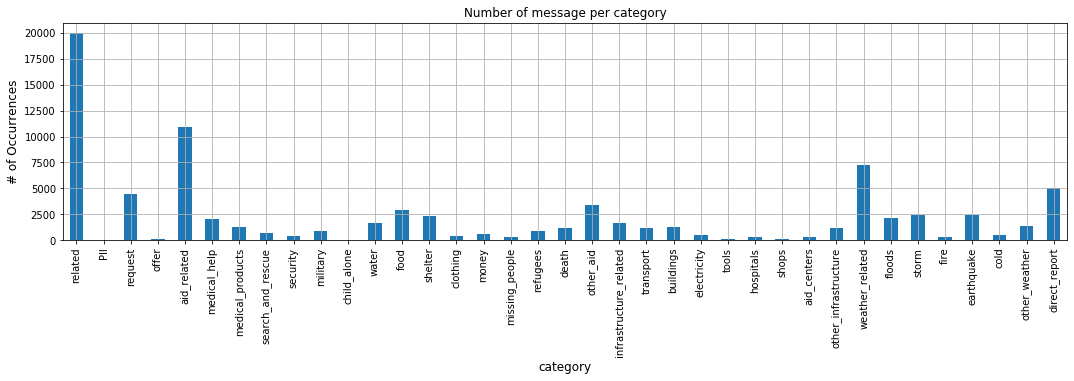

In [31]:
#Plot histogram to visualise the distribution of multilabels
df_stats.plot(x='category', y='number_of_message', kind='bar', legend=False, grid=True, figsize=(18, 4))
plt.title("Number of message per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12);

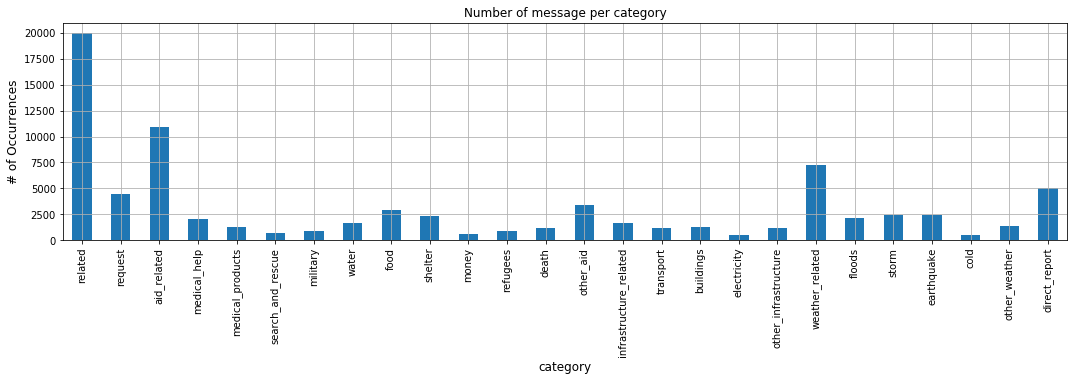

In [32]:
df_stats = df_stats[df_stats['number_of_message'] > 500]

df_stats.plot(x='category', y='number_of_message', kind='bar', legend=False, grid=True, figsize=(18, 4))
plt.title("Number of message per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12);

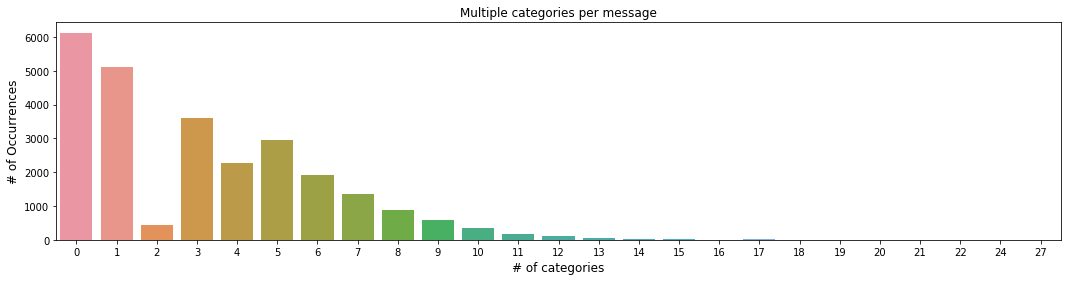

In [35]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#To see the number of messages with multiple categories
plt.figure(figsize=(18,4))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per message")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12);

In [36]:
# Based on the EDA, 70% of the categories are less than 5% of the total data set.
# Most of the categories does not classify the severity of the message. It suggest insights like, requesting for shelter, food, type of disaster etc
# We concluded that we will build a binary classification model.

In [12]:
#Baseline -Imbalanced dataset. Will upsize at the later part
df['related'].value_counts(normalize=True)

1    0.76492
0    0.23508
Name: related, dtype: float64

In [13]:
features = ['message', 'genre','related']
df = df[features]

In [14]:
df['genre'].value_counts()

news      13050
direct    10645
social     2360
Name: genre, dtype: int64

In [15]:
df = df[df['genre'] == 'direct']

In [16]:
df.head(1)

,message,genre,related
0,UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.,direct,1


In [17]:
df.isnull().sum()

message    0
genre      0
related    0
dtype: int64

In [49]:
df.duplicated().sum()

23

In [50]:
#Drop 23 rows of duplicates
df = df.drop_duplicates()

In [51]:
df.shape

(10622, 3)

In [52]:
df['related'].value_counts(normalize=True)

1    0.675014
0    0.324986
Name: related, dtype: float64

In [53]:
def clean_text(text):
    # remove HTML tags and URLs
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'^https?:\/\/.*[\r\n]*','',text)
    # keep only text without punctuation
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(" \d+", " ", text)
    # convert text to lowercase
    text = text.strip().lower()
    # split text into a list of words
    token_text = re.split('\W+',text) #W+ --> word chars and dashes permitted
    return token_text

In [54]:
df['message'] = df['message'].apply(lambda x: clean_text(x))
df.head()

,message,genre,related
0,"[un, reports, leogane, destroyed, only, hospital, st, croix, functioning, needs, supplies, desperately]",direct,1
1,"[we, are, at, gressier, we, needs, assistance, right, away, asap, come, help, us]",direct,1
2,"[delmas, in, silo, need, water]",direct,1
3,"[sos, sos, please, provide, police, officers, on, the, streets, as, they, are, very, insecure]",direct,1
4,"[i, am, a, driver, a, mechanic, i, want, to, help]",direct,1


In [55]:
#from sklearn.feature_extraction import text

#text.ENGLISH_STOP_WORDS
#add_stop_words = ['000', 'affected', 'area', 'day', 'good', 'know', 'like', 'said', 'year', 'city']

#stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)
stop_words = stopwords.words('english')
stop_words

df['message'] = df['message'].apply(lambda x: [item for item in x if item not in stop_words])
df.head()

,message,genre,related
0,"[un, reports, leogane, destroyed, hospital, st, croix, functioning, needs, supplies, desperately]",direct,1
1,"[gressier, needs, assistance, right, away, asap, come, help, us]",direct,1
2,"[delmas, silo, need, water]",direct,1
3,"[sos, sos, please, provide, police, officers, streets, insecure]",direct,1
4,"[driver, mechanic, want, help]",direct,1


In [56]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    lemma_words = [lemmatizer.lemmatize(word) for word in text]
    return lemma_words

In [57]:
df['message'] = df['message'].apply(lambda x: lemmatize_words(x))
df.head()

,message,genre,related
0,"[un, report, leogane, destroyed, hospital, st, croix, functioning, need, supply, desperately]",direct,1
1,"[gressier, need, assistance, right, away, asap, come, help, u]",direct,1
2,"[delmas, silo, need, water]",direct,1
3,"[so, so, please, provide, police, officer, street, insecure]",direct,1
4,"[driver, mechanic, want, help]",direct,1


In [58]:
df['message'] = df['message'].apply(lambda x: " ".join(x))
df.head()

,message,genre,related
0,un report leogane destroyed hospital st croix functioning need supply desperately,direct,1
1,gressier need assistance right away asap come help u,direct,1
2,delmas silo need water,direct,1
3,so so please provide police officer street insecure,direct,1
4,driver mechanic want help,direct,1


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10622 entries, 0 to 24875
Data columns (total 3 columns):
message    10622 non-null object
genre      10622 non-null object
related    10622 non-null int64
dtypes: int64(1), object(2)
memory usage: 331.9+ KB


In [60]:
# Easy way to get most frequently used words: change max_features

count_vect = CountVectorizer(analyzer = "word", 
                             tokenizer = None, 
                             preprocessor = None,
                             stop_words = "english", 
                             max_features = 50) 

# input for CountVectorizer is an array of strings
vector_input_cats = df[df['related'] == 1]['message']

# fit_transform the vectorizer
cat_words = count_vect.fit_transform(vector_input_cats)

# convert output to a Numpy array
cat_words = cat_words.toarray()

In [61]:
cat_word_list = count_vect.get_feature_names()
print(cat_word_list)

['aid', 'area', 'asking', 'baby', 'card', 'carrefour', 'child', 'come', 'country', 'delmas', 'destroyed', 'dont', 'earthquake', 'family', 'food', 'god', 'going', 'good', 'haiti', 'hello', 'help', 'house', 'hunger', 'hungry', 'im', 'information', 'know', 'like', 'live', 'lost', 'lot', 'message', 'need', 'people', 'portauprince', 'problem', 'rain', 'school', 'send', 'shelter', 'sleep', 'street', 'supply', 'tent', 'thank', 'thanks', 'victim', 'want', 'water', 'work']


In [62]:
df.isnull().sum()

message    0
genre      0
related    0
dtype: int64

In [63]:
df.shape

(10622, 3)

In [64]:
df.to_csv("../data/final_cleaned.csv", index = False)